<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2
</center>
Автор материала: Илья Барышников. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center> Домашнее задание №2
## <center> Визуальный анализ данных о сердечно-сосудистых заболеваниях

**В задании предлагается с помощью визуального анализа ответить на несколько вопросов по данным о сердечно-сосудистых заболеваниях. Данные использовались в соревновании [Ml Boot Camp 5](http://mlbootcamp.ru/round/12/sandbox/) (качать их не надо, они уже есть в репозитории).**

**Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://goo.gl/H5uTYg).**

В соревновании предлагалось определить наличие/отсутствие сердечно-сосудистых заболеваний (ССЗ) по результатам осмотра пациента.

**Описание данных.**

Объективные признаки:

 - Возраст (age)
 - Рост (height)
 - Вес (weight)
 - Пол (gender)
 

Результаты измерения:

 - Артериальное давление верхнее и нижнее (ap_hi, ap_lo)
 - Холестерин (cholesterol)
 - Глюкоза (gluc)
 

Субъективные признаки (со слов пациентов):

 - Курение (smoke)
 - Употребление алкоголя (alco)
 - Физическая активность (active)
 
Целевой признак (который интересно будет прогнозировать):
 - Наличие сердечно-сосудистых заболеваний по результатам классического врачебного осмотра (cardio)

Значения показателей холестерина и глюкозы представлены одним из трех классов: норма, выше нормы, значительно выше нормы. Значения субъективных признаков — бинарны.

Все показатели даны на момент осмотра.

In [1]:
# подгружаем все нужные пакеты
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
%matplotlib inline

# настройка внешнего вида графиков в seaborn
sns.set_context(
    "notebook", 
    font_scale = 1.5,       
    rc = { 
        "figure.figsize" : (12, 9), 
        "axes.titlesize" : 18 
    }
)

# Проведем небольшой EDA

In [2]:
train = pd.read_csv('D:\\Yorko\\mlcourse_open\\data\\mlbootcamp5_train.csv', sep=';',
                    index_col='id')

In [4]:
print('Размер датасета: ', train.shape)
train.head(6)

Размер датасета:  (70000, 12)


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0
8,21914,1,151,67.0,120,80,2,2,0,0,0,0


Для начала всегда неплохо бы посмотреть на значения, которые принимают переменные.

Переведем данные в "Long Format"-представление и отрисуем с помощью [factorplot](https://seaborn.pydata.org/generated/seaborn.factorplot.html) количество значений, которые принимают категориальные переменные.

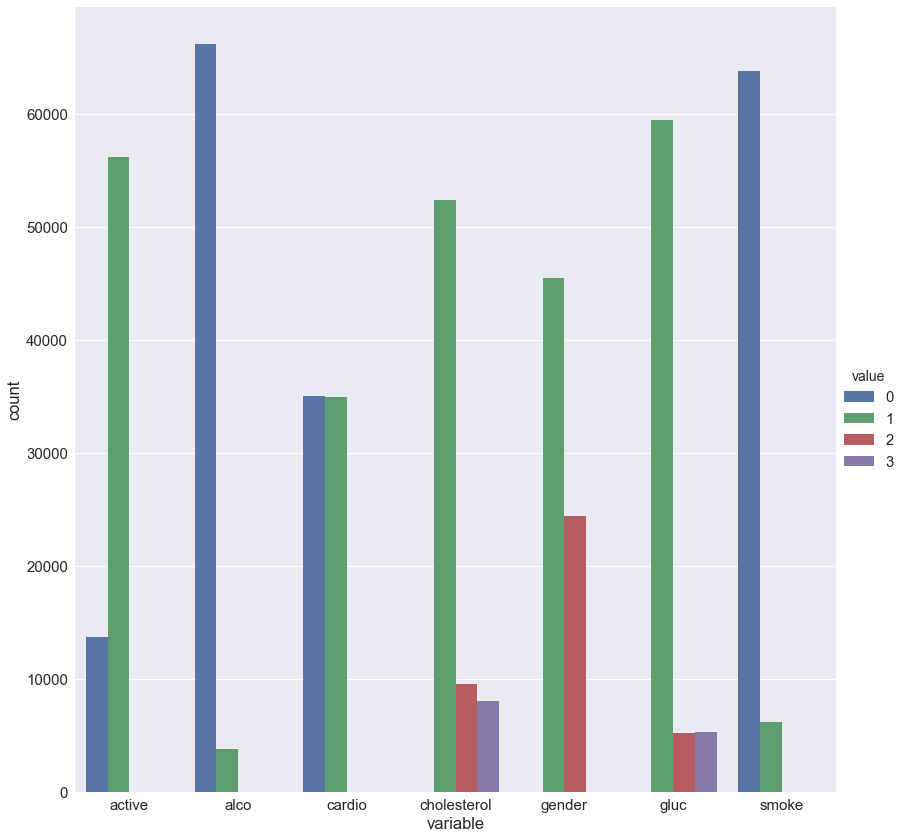

In [5]:
train_uniques = pd.melt(frame=train, value_vars=['gender','cholesterol', 
                                                 'gluc', 'smoke', 'alco', 
                                                 'active', 'cardio'])
train_uniques = pd.DataFrame(train_uniques.groupby(['variable', 
                                                    'value'])['value'].count()) \
    .sort_index(level=[0, 1]) \
    .rename(columns={'value': 'count'}) \
    .reset_index()
    
sns.factorplot(x='variable', y='count', hue='value', 
               data=train_uniques, kind='bar', size=12);

Видим, что классы целевой переменно сбалансированы, отлично!

Можно также разбить элементы обучающей выборки по значениям целевой переменной: иногда на таких графиках можно сразу увидеть самый значимый признак.

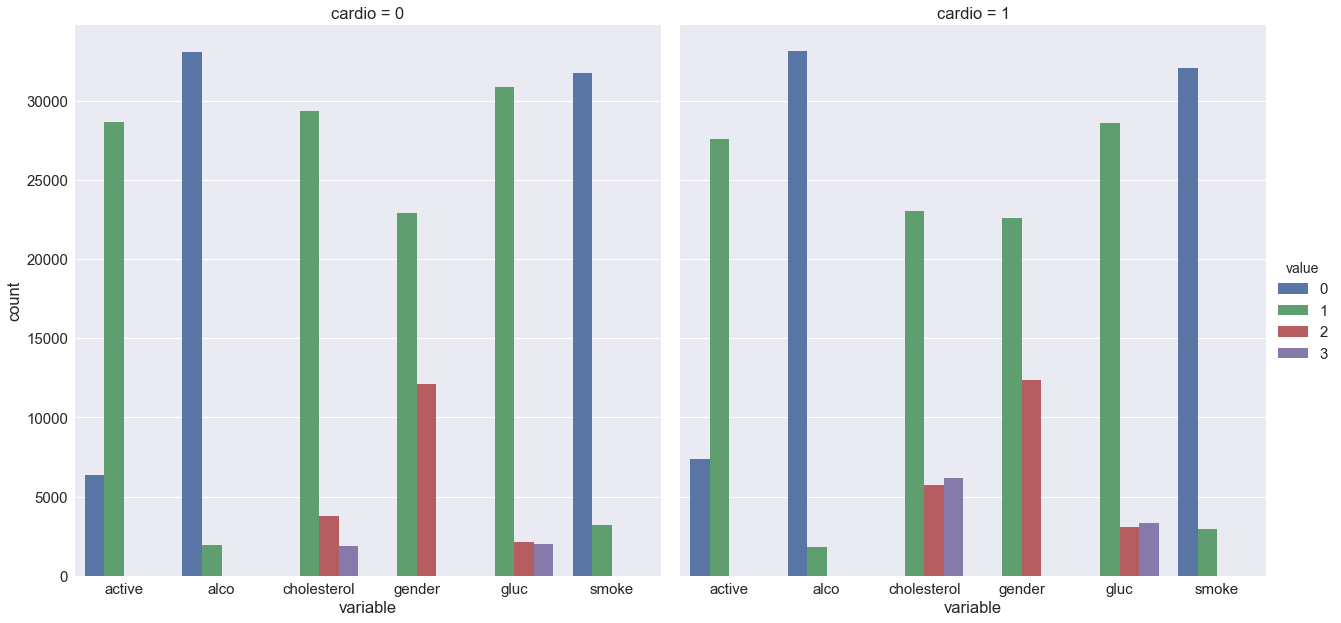

In [6]:
train_uniques = pd.melt(frame=train, value_vars=['gender','cholesterol', 
                                                 'gluc', 'smoke', 'alco', 
                                                 'active'], 
                        id_vars=['cardio'])
train_uniques = pd.DataFrame(train_uniques.groupby(['variable', 'value', 
                                                    'cardio'])['value'].count()) \
    .sort_index(level=[0, 1]) \
    .rename(columns={'value': 'count'}) \
    .reset_index()
    
sns.factorplot(x='variable', y='count', hue='value', 
               col='cardio', data=train_uniques, kind='bar', size=9);

Видим, что в зависимости от целевой переменной сильно меняется распределение холестерина и глюкозы. Совпадение?

**Немного статистики по уникальным значениям признаков.**

In [7]:
for c in train.columns:
    n = train[c].nunique()
    print(c)
    
    if n <= 3:
        print(n, sorted(train[c].value_counts().to_dict().items()))
    else:
        print(n)
    print(10 * '-')

age
8076
----------
gender
2 [(1, 45530), (2, 24470)]
----------
height
109
----------
weight
287
----------
ap_hi
153
----------
ap_lo
157
----------
cholesterol
3 [(1, 52385), (2, 9549), (3, 8066)]
----------
gluc
3 [(1, 59479), (2, 5190), (3, 5331)]
----------
smoke
2 [(0, 63831), (1, 6169)]
----------
alco
2 [(0, 66236), (1, 3764)]
----------
active
2 [(0, 13739), (1, 56261)]
----------
cardio
2 [(0, 35021), (1, 34979)]
----------


*Итого:*
- Пять количественных признаков (без id)
- Семь категориальных
- 70000 элементов

---

# 1. Визуализируем корреляционную матрицу

Для того, чтобы лучше понять признаки в датасете, можно посчитать матрицу коэффициентов корреляции между признаками. <br>

Постройте [heatmap](http://seaborn.pydata.org/generated/seaborn.heatmap.html) корреляционной матрицы. Матрица формируется средствами *pandas*, со стандартным значением параметров.

###  1. Какие два признака больше всего коррелируют (по Пирсону) с признаком `gender` ?

- Cardio, Cholesterol
- Height, Smoke
- Smoke, Alco
- Height, Weight

                  age    gender    height    weight     ap_hi     ap_lo  \
age          1.000000 -0.022811 -0.081515  0.053684  0.020764  0.017647   
gender      -0.022811  1.000000  0.499033  0.155406  0.006005  0.015254   
height      -0.081515  0.499033  1.000000  0.290968  0.005488  0.006150   
weight       0.053684  0.155406  0.290968  1.000000  0.030702  0.043710   
ap_hi        0.020764  0.006005  0.005488  0.030702  1.000000  0.016086   
ap_lo        0.017647  0.015254  0.006150  0.043710  0.016086  1.000000   
cholesterol  0.154424 -0.035821 -0.050226  0.141768  0.023778  0.024019   
gluc         0.098703 -0.020491 -0.018595  0.106857  0.011841  0.010806   
smoke       -0.047633  0.338135  0.187989  0.067780 -0.000922  0.005186   
alco        -0.029723  0.170966  0.094419  0.067113  0.001408  0.010601   
active      -0.009927  0.005866 -0.006570 -0.016867 -0.000033  0.004780   
cardio       0.238159  0.008109 -0.010821  0.181660  0.054475  0.065719   

             cholesterol

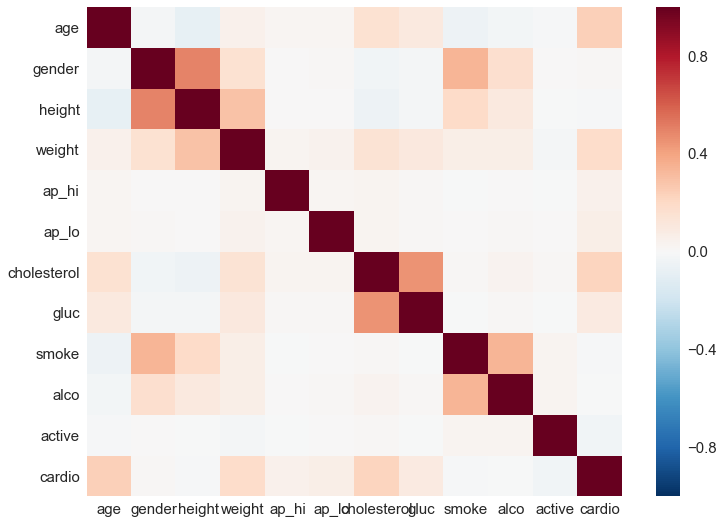

In [10]:
cormat1 = train.corr(method = 'pearson')
print(cormat1)
sns.heatmap(cormat1)

---

# 2. Распределение роста для мужчин и женщин

Как мы увидели, в процессе исследования уникальных значений, пол кодируется значениями 1 и 2, расшифровка изначально не была нам дана в описании данных, но мы догадались, кто есть кто, посчитав средние значения роста (или веса) при разных значениях признака `gender`. Теперь сделаем то же самое, но графически. 

Постройте [violinplot](https://seaborn.pydata.org/generated/seaborn.violinplot.html) для роста и пола. Используйте:
- hue – для разбивки по полу
- scale – для оценки количества каждого из полов 

Для корректной отрисовки, преобразуйте DataFrame в "Long Format"-представление с помощью функции melt в pandas.
<br>
[еще один пример](https://stackoverflow.com/a/41575149/3338479)

Постройте на одном графике два отдельных [kdeplot](https://seaborn.pydata.org/generated/seaborn.kdeplot.html) роста, отдельно для мужчин и женщин. На нем разница будет более наглядной, но нельзя будет оценить количество мужчин/женщин.

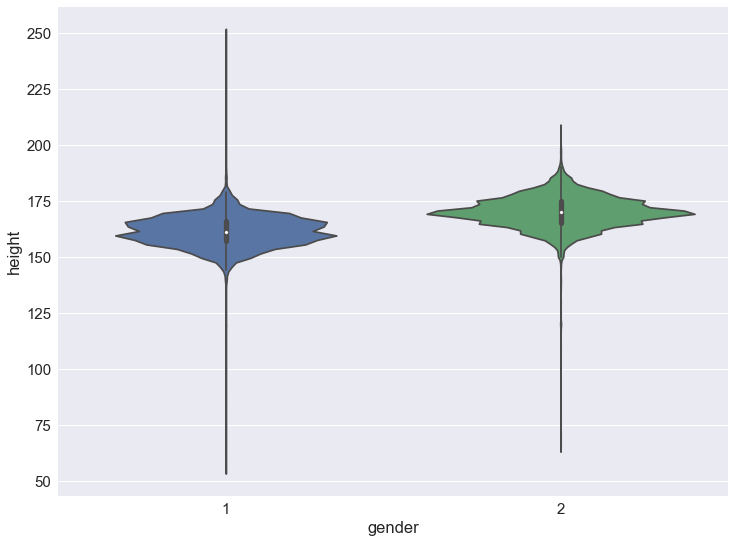

In [44]:
train['myheight'] = train['height']/train.height.max()
train['mygender'] = train['gender'] - 1
df = pd.melt(train, value_vars=['myheight','mygender'])
df.head()
#sns.violinplot(x = "variable", y = "value", hue = "variable", data = df, scale = "count")
sns.violinplot(y = "height", x = "gender", data = train, scale = "area")

C:\Users\user\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


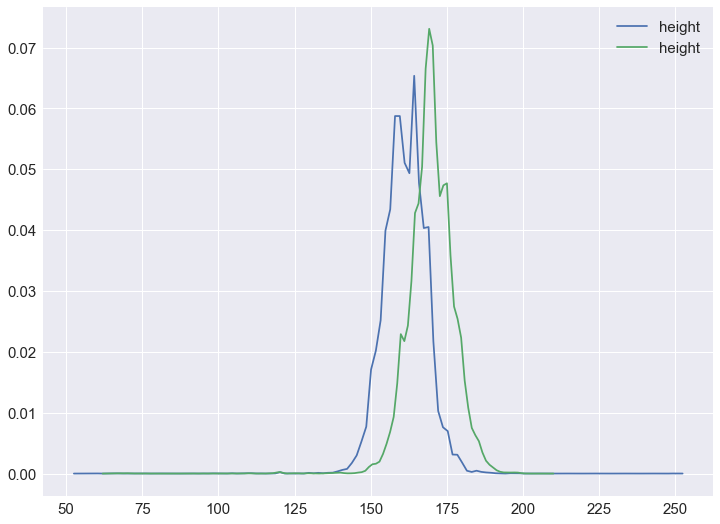

In [45]:
sns.kdeplot(train.height[train.gender == 1])
sns.kdeplot(train.height[train.gender == 2])


---

# 3. Ранговая корреляция

В большинстве случаев достаточно воспользоваться линейным коэффициентом корреляции *Пирсона* для выявления закономерностей в данных, но мы пойдем чуть дальше и используем ранговую корреляцию, которая поможет нам выявить пары, в которых меньший ранг из вариационного ряда одного признака всегда предшествует большему другого (или наоборот, в случае отрицательной корреляции).

** Постройте корреляционную матрицу, используя коэффициент Спирмена**

### 3.1 Какие признаки теперь больше всего коррелируют (по Спирмену) друг с другом?

- Height, Weight
- Age, Weight
- Cholesterol, Gluc
- Cardio, Cholesterol
- Ap_hi, Ap_lo
- Smoke, Alco

                  age    gender    height    weight     ap_hi     ap_lo  \
age          1.000000 -0.020176 -0.082292  0.061559  0.219087  0.156700   
gender      -0.020176  1.000000  0.533805  0.172480  0.063174  0.066374   
height      -0.082292  0.533805  1.000000  0.313569  0.019381  0.030534   
weight       0.061559  0.172480  0.313569  1.000000  0.277749  0.254420   
ap_hi        0.219087  0.063174  0.019381  0.277749  1.000000  0.735436   
ap_lo        0.156700  0.066374  0.030534  0.254420  0.735436  1.000000   
cholesterol  0.140113 -0.035730 -0.058940  0.137908  0.208722  0.167401   
gluc         0.091791 -0.018866 -0.024369  0.109901  0.105334  0.082474   
smoke       -0.047471  0.338135  0.197632  0.071676  0.028929  0.026172   
alco        -0.030078  0.170966  0.096670  0.068088  0.033243  0.038862   
active      -0.010422  0.005866 -0.007367 -0.014894 -0.001268  0.003401   
cardio       0.234429  0.008109 -0.012383  0.182701  0.451885  0.362572   
myheight    -0.082292  0.

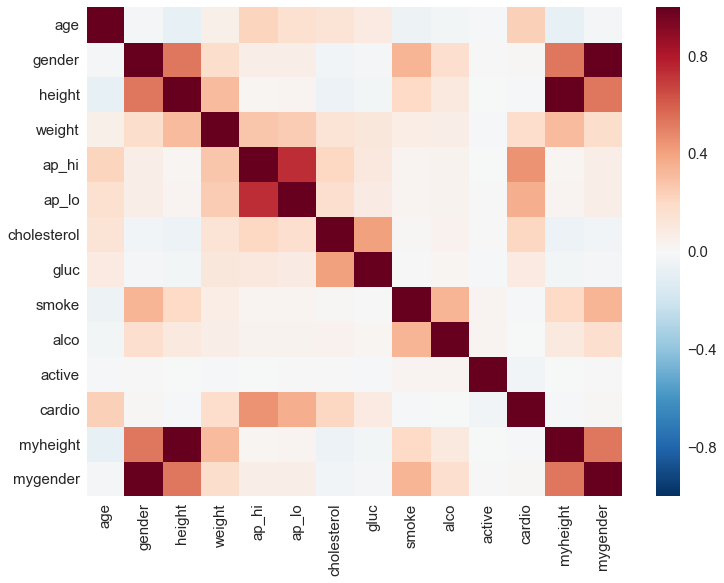

In [46]:
cormat2 = train.corr(method = "spearman")
print(cormat2)
sns.heatmap(cormat2)

### 3.2 Почему мы получили такое большое (относительно) значение ранговой корреляции у этих признаков?

- Неточности в данных (ошибки при сборе данных)
- Связь ошибочна, переменные никак не должны быть связаны друг с другом
- Природа данных

In [86]:
train2 = train[train.ap_hi >= train.ap_lo]
train3 = train[train.ap_hi > train.ap_lo]
print(train2.ap_hi.corr(train2.ap_lo, method = "spearman"))
print(train.ap_hi.corr(train.ap_lo, method = "spearman"))
print(train3.ap_hi.corr(train3.ap_lo, method = "spearman"))
train4 = train[(train.ap_hi > train.ap_lo) & (train.ap_lo > 0) & (train.ap_hi<260)]
print(len(train4))
print(train4.ap_hi.corr(train.ap_lo, method = "spearman"))

0.740658842833
0.735436105138
0.740803383242
68709
0.742536886528


# 4. Совместное распределение признаков

Постройте совместный график распределения [jointplot](http://seaborn.pydata.org/generated/seaborn.jointplot.html) двух наиболее коррелирующих между собой признаков (по Спирмену).

Кажется, наш график получился неинформативным из-за выбросов в значениях. Постройте тот же график, но с логарифмической шкалой.

                age        gender        height        weight         ap_hi  \
count  70000.000000  70000.000000  70000.000000  70000.000000  70000.000000   
mean   19468.865814      1.349571    164.359229     74.205690    128.817286   
std     2467.251667      0.476838      8.210126     14.395757    154.011419   
min    10798.000000      1.000000     55.000000     10.000000   -150.000000   
25%    17664.000000      1.000000    159.000000     65.000000    120.000000   
50%    19703.000000      1.000000    165.000000     72.000000    120.000000   
75%    21327.000000      2.000000    170.000000     82.000000    140.000000   
max    23713.000000      2.000000    250.000000    200.000000  16020.000000   

              ap_lo   cholesterol          gluc         smoke          alco  \
count  70000.000000  70000.000000  70000.000000  70000.000000  70000.000000   
mean      96.630414      1.366871      1.226457      0.088129      0.053771   
std      188.472530      0.680250      0.572270    

C:\Users\user\Anaconda3\lib\site-packages\ipykernel\__main__.py:24: RuntimeWarning: invalid value encountered in log
C:\Users\user\Anaconda3\lib\site-packages\ipykernel\__main__.py:25: RuntimeWarning: invalid value encountered in log
C:\Users\user\Anaconda3\lib\site-packages\ipykernel\__main__.py:27: RuntimeWarning: divide by zero encountered in log
C:\Users\user\Anaconda3\lib\site-packages\ipykernel\__main__.py:27: RuntimeWarning: invalid value encountered in log
C:\Users\user\Anaconda3\lib\site-packages\ipykernel\__main__.py:28: RuntimeWarning: divide by zero encountered in log
C:\Users\user\Anaconda3\lib\site-packages\ipykernel\__main__.py:28: RuntimeWarning: invalid value encountered in log


OverflowError: cannot convert float infinity to integer

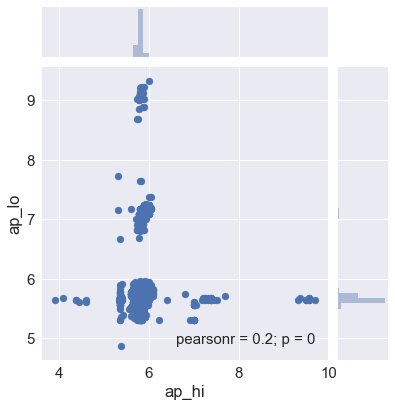

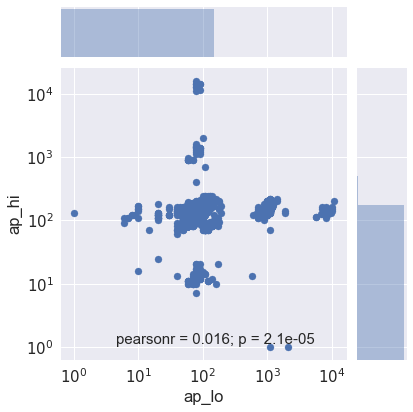

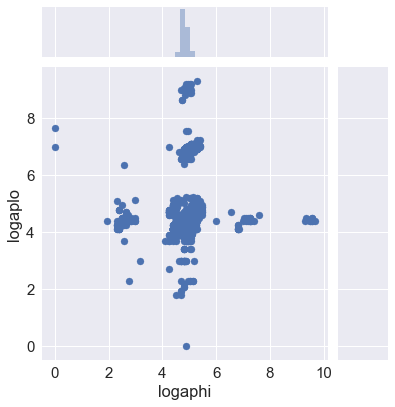

In [95]:
# Ваш код здесь

# -------------------- #

print(train.describe())

sns.jointplot(np.log(200+train['ap_hi']), np.log(200+train['ap_lo']))


#"""Сетка"""
#g.ax_joint.grid(True) 

#"""Преобразуем логарифмические значения на шкалах в реальные"""
#g.ax_joint.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: str(round(int(np.exp(x))))))
#g.ax_joint.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: str(round(int(np.exp(x))))))

g = sns.jointplot(x ='ap_lo' , y ='ap_hi', data = train)
ax = g.ax_joint
ax.set_xscale('log')
ax.set_yscale('log')

mytrain = train
mytrain['logaphi'] = 0
mytrain.loc[mytrain.ap_hi>0, 'logaphi'] = np.log(mytrain.ap_hi)
mytrain.loc[mytrain.ap_hi<0, 'logaphi'] = -np.log(mytrain.ap_hi)
mytrain['logaplo'] = 0
mytrain.loc[mytrain.ap_hi>0, 'logaplo'] = np.log(mytrain.ap_lo)
mytrain.loc[mytrain.ap_hi<0, 'logaplo'] = -np.log(mytrain.ap_lo)

sns.jointplot(train['logaphi'], train['logaplo'])


### 4.1 Сколько четко выраженных кластеров получилось на  совместном графике выбранных признаков, с логарифмической шкалой?

- 1
- 2
- 3
- больше трех

       ap_hi     ap_lo
id                    
0   4.700480  4.382027
1   4.941642  4.499810
2   4.867534  4.248495
3   5.010635  4.605170
4   4.605170  4.094345
15


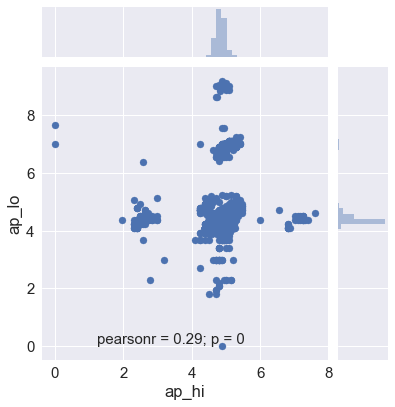

In [96]:
train2 = train[(train.ap_hi>0) & (train.ap_lo>0) & (train.ap_hi<10000) & (train.ap_lo<10000)]
sns.jointplot(np.log(train2['ap_hi']), np.log(train2['ap_lo']))

htab = train2[['ap_hi', 'ap_lo']].apply(lambda x: np.log(x))
print(htab.head())

import hdbscan
model = hdbscan.HDBSCAN(min_cluster_size = 1000)
res = model.fit_predict(htab)
print(res.max())

In [ ]:
sns.jointplot()

---

# 5. Barplot

Посчитаем, сколько полных лет было респондентам на момент их занесения в базу.

In [64]:
train['age_years'] = (train['age'] // 365.25).astype(int)


Постройте [Countplot](http://seaborn.pydata.org/generated/seaborn.countplot.html), где на оси абсцисс будет отмечен возраст, на оси ординат – количество. Каждое значение возраста должно иметь два столбца, соответствующих количеству человек каждого класса **cardio** данного возраста.

### 5. В каком возрасте количество пациентов с ССЗ  впервые становится больше, чем здоровых?
- 44
- 53
- 64
- 70

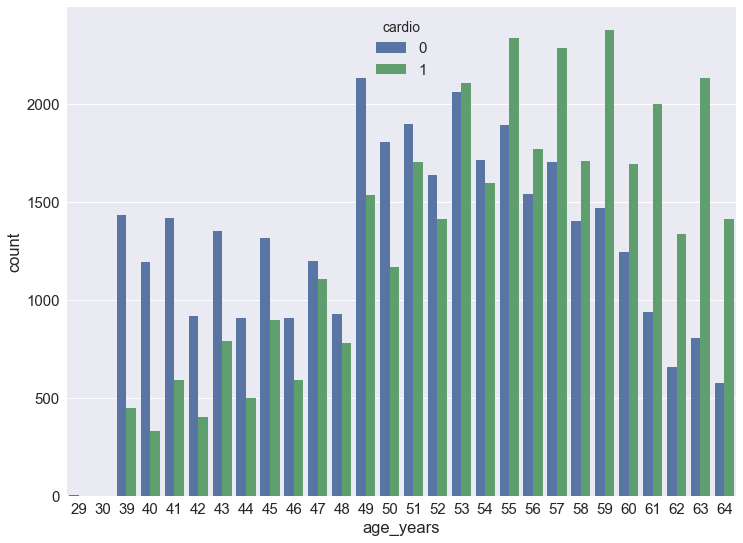

In [70]:
sns.countplot(x = train.age_years, hue = "cardio", data = train)